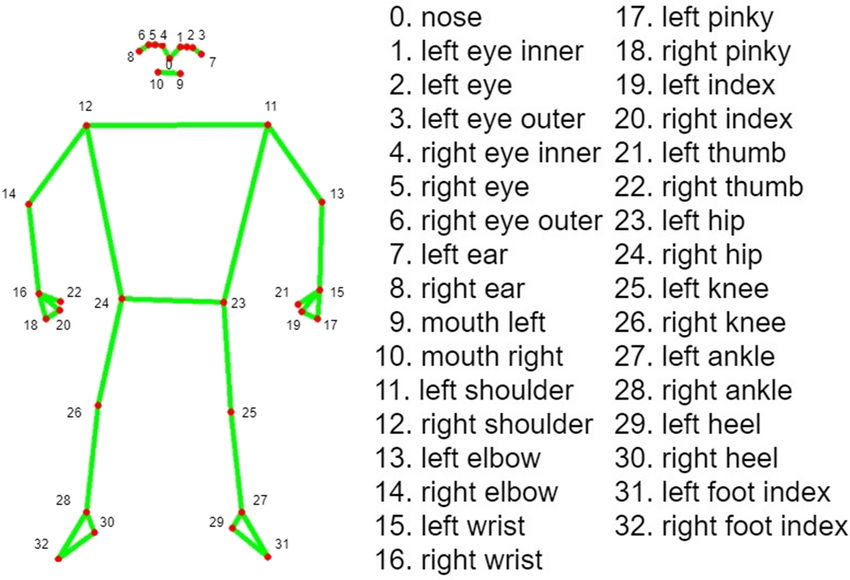

In [36]:
#0. mports
from __future__ import annotations
import os
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import pandas as pd
import mediapipe as mp
import cv2
from collections import deque
from pathlib import Path

In [37]:
# 2. Set device
DEVICE = torch.device("mps") if torch.backends.mps.is_available() else \
         torch.device("cuda") if torch.cuda.is_available() else \
         torch.device("cpu")
print("► Using device:", DEVICE)

CKPT_FILE = "kp_pose_quality_windows_ex.pt"

► Using device: mps


In [38]:
# 2. Helper functions and constants

# Joint names and counts
PoseLandmark = mp.solutions.pose.PoseLandmark
JOINT_NAMES = [lm.name for lm in PoseLandmark]
N_JOINTS = len(JOINT_NAMES)
print("► Joint names:", JOINT_NAMES)
print("► Number of joints:", N_JOINTS)

NUM_EXERCISES = 6
ERR_JOINTS = [
    "LEFT_ELBOW", "RIGHT_ELBOW",
    "LEFT_SHOULDER", "RIGHT_SHOULDER",
    "LEFT_HIP", "RIGHT_HIP",
    "LEFT_KNEE", "RIGHT_KNEE",
    "SPINE", "HEAD",
]
N_ERR = len(ERR_JOINTS)

# Exercise map
EXERCISE_MAP = {
    1: "Arm abduction",
    2: "Arm VW",
    3: "Push-ups",
    4: "Leg abduction",
    5: "Leg lunge",
    6: "Squats"
}

# Feedback helper
FRIENDLY = {j: " ".join(j.split("_")).lower() for j in ERR_JOINTS}
ACTION_VERBS = {
    "elbow": ("flex", "extend"),
    "shoulder": ("rotate back", "rotate forward"),
    "knee": ("bend", "straighten"),
    "hip": ("lower", "lift"),
    "spine": ("arch", "tuck"),
}

def magnitude_adverb(d):
    a = abs(d)
    return "slightly" if a < 5 else "noticeably" if a < 15 else "significantly"

def get_action(part, d):
    for k, (neg, pos) in ACTION_VERBS.items():
        if k in part: return neg if d < 0 else pos
    return "move"

def english_feedback(err_vec, tol=5.0):
    joints = [(i, e) for i, e in enumerate(err_vec) if abs(e) > tol]
    if not joints:
        return ["✅ Perfect form!"]
    joints = sorted(joints, key=lambda x: abs(x[1]), reverse=True)[:3]
    tips = []
    for i, e in joints:
        name = ERR_JOINTS[i]
        part = FRIENDLY[name]
        adv = magnitude_adverb(e).capitalize()
        verb = get_action(part, e)
        tips.append(f"{adv} {verb} your {part} by {abs(e):.1f}°")
    return tips

► Joint names: ['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER', 'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX', 'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL', 'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX']
► Number of joints: 33


In [39]:
# 3. Model definitions
class KeypointEncoder(nn.Module):
    def __init__(self, in_dim: int, embed: int = 512):
        super().__init__()
        self.conv1 = nn.Conv1d(in_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, embed, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        return x

class PoseQualityNetKP(nn.Module):
    def __init__(self, in_dim: int, num_ex: int, hidden: int = 256, ex_emb: int = 64):
        super().__init__()
        self.encoder = KeypointEncoder(in_dim)
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden, num_layers=2, batch_first=True, bidirectional=True)
        feat_dim = hidden * 2
        self.ex_emb = nn.Sequential(
            nn.Linear(num_ex, ex_emb),
            nn.ReLU(),
            nn.Linear(ex_emb, ex_emb)
        )
        self.cls_head = nn.Linear(feat_dim + ex_emb, 2)
        self.err_head = nn.Linear(feat_dim + ex_emb, N_ERR)

    def forward(self, seq: torch.Tensor, ex_1hot: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        B, T, D = seq.shape
        encoded_frames = [self.encoder(seq[:, t, :]) for t in range(T)]
        feats = torch.stack(encoded_frames, dim=1)
        out, _ = self.lstm(feats)
        g = out.mean(dim=1)
        ex_e = self.ex_emb(ex_1hot)
        h = torch.cat([g, ex_e], dim=1)
        logits = self.cls_head(h)
        err_hat = self.err_head(h)
        return logits, err_hat


In [40]:

# 4. Load model
if not Path(CKPT_FILE).exists():
    print(f"Error: Checkpoint file not found at {CKPT_FILE}")
    exit()

print(f"Loading model from {CKPT_FILE}...")
infer_model = torch.load(CKPT_FILE, map_location=DEVICE)
infer_model.eval()
print("✅ Model loaded.")

# MediaPipe setup
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)


Loading model from kp_pose_quality_windows_ex.pt...
✅ Model loaded.


/var/folders/pv/99z70cjs7t1dx16_0r1c33hw0000gn/T/ipykernel_25072/1868343976.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  infer_model = torch.load(CKPT_FILE, map_locat

In [41]:

# 5. Inference loop setup
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

frames = 16
buffer = deque(maxlen=frames)

# Ask user for exercise ID
while True:
    try:
        exercise_id_str = input(f"Enter the exercise ID you're performing (1-{NUM_EXERCISES}): ")
        exercise_id = int(exercise_id_str)
        if 1 <= exercise_id <= NUM_EXERCISES:
            exercise_name = EXERCISE_MAP[exercise_id]
            break
        else:
            print(f"Invalid ID. Please enter a number between 1 and {NUM_EXERCISES}.")
    except ValueError:
        print("Invalid input. Please enter a number.")

W0000 00:00:1744992110.967039  915482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744992110.974346  915487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [42]:
# 6. Prepare one-hot encoding for exercise
ex_1hot = torch.zeros(1, NUM_EXERCISES, device=DEVICE)
ex_1hot[0, exercise_id - 1] = 1

In [ ]:
# Predict from file

# 7. Feedback loop for video file prediction
print("✅ Starting video inference…")
print("▶ Press ESC to quit")

# Initialize feedback variables
feedback_color = (200, 200, 0)  # Yellow for buffering

# Set the exercise name (Example: Exercise 2)
exercise_name = "Exercise 2"

# Load the video file
SCRIPT_DIR = Path().resolve()
VIDEO_PATH = SCRIPT_DIR / "Data-REHAB24-6/Videos/Ex2/PM_003-Camera17-30fps.mp4"  # Adjust the path to your video file
cap = cv2.VideoCapture(str(VIDEO_PATH))

if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# MediaPipe Pose setup
mp_pose = mp.solutions.pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    enable_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

# Initialize the buffer for keypoints (you may need this for multiple frames)
buffer = []

while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    # Flip the frame for mirror image
    img_flipped = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(img_flipped, cv2.COLOR_BGR2RGB)

    rgb.flags.writeable = False
    results = mp_pose.process(rgb)
    rgb.flags.writeable = True
    img_display = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            img_display, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()
        )
        kp = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark], dtype=np.float32).flatten()
        buffer.append(kp)

    # Assuming you want to perform prediction once you have enough frames in the buffer
    if len(buffer) == 16:  # For example, 16 frames for prediction
        window_np = np.stack(buffer)
        window = torch.tensor(window_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            logits, err_hat = infer_model(window, ex_1hot)

        pred = logits.argmax(1).item()  # 0 = Incorrect, 1 = Correct

        # Set feedback color based on classification result
        feedback_color = (0, 255, 0) if pred == 1 else (0, 0, 255)

        # Display "Correct" or "Incorrect" on the screen
        correctness_text = "Correct" if pred == 1 else "Incorrect"
        cv2.putText(img_display, correctness_text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, feedback_color, 2)

        buffer.clear()

    # Display the current exercise
    exercise_text = f"Exercise: {exercise_name}"
    cv2.putText(img_display, exercise_text, (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Show the processed image with feedback
    cv2.imshow("Live Pose Feedback", img_display)

    if cv2.waitKey(1) & 0xFF == 27:  # Exit on pressing ESC
        print("ESC pressed, exiting...")
        break

cap.release()
cv2.destroyAllWindows()
mp_pose.close()
print("Resources released.")


✅ Starting video inference…
▶ Press ESC to quit


I0000 00:00:1744992334.197458  905848 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Max
W0000 00:00:1744992334.250825  918466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744992334.273140  918476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


ESC pressed, exiting...
Resources released.


In [ ]:
# # Predict from camersa Correct or incorrect only

# # 7. Feedback loop
# print("✅ Starting live inference…")
# print("▶ Press ESC to quit")

# # Initialize feedback variables
# feedback_color = (200, 200, 0)  # Yellow for buffering

# # Set the exercise name (You can dynamically set this based on the exercise you're performing)
# exercise_name = "Exercise 1"  # Example: You can change this dynamically depending on the exercise

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         print("Error: Failed to capture frame.")
#         break

#     img_flipped = cv2.flip(frame, 1)
#     rgb = cv2.cvtColor(img_flipped, cv2.COLOR_BGR2RGB)

#     rgb.flags.writeable = False
#     results = mp_pose.process(rgb)
#     rgb.flags.writeable = True
#     img_display = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

#     if results.pose_landmarks:
#         mp_drawing.draw_landmarks(
#             img_display, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
#             landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()
#         )
#         kp = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark], dtype=np.float32).flatten()
#         buffer.append(kp)

#     if len(buffer) == frames:
#         window_np = np.stack(buffer)
#         window = torch.tensor(window_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)

#         with torch.no_grad():
#             logits, err_hat = infer_model(window, ex_1hot)

#         pred = logits.argmax(1).item()  # 0 = Incorrect, 1 = Correct

#         # Set feedback color based on classification result
#         feedback_color = (0, 255, 0) if pred == 1 else (0, 0, 255)

#         # Display "Correct" or "Incorrect" on the screen
#         correctness_text = "Correct" if pred == 1 else "Incorrect"
#         cv2.putText(img_display, correctness_text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, feedback_color, 2)

#         buffer.clear()

#     # Display the current exercise
#     exercise_text = f"Exercise: {exercise_name}"
#     cv2.putText(img_display, exercise_text, (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

#     # Display the processed image with feedback
#     cv2.imshow("Live Pose Feedback", img_display)

#     if cv2.waitKey(1) & 0xFF == 27:  # Exit on pressing ESC
#         print("ESC pressed, exiting...")
#         break

# cap.release()
# cv2.destroyAllWindows()
# mp_pose.close()
# print("Resources released.")


✅ Starting live inference…
▶ Press ESC to quit
ESC pressed, exiting...
Resources released.


In [44]:
# # 7. Feedback loop
# print("✅ Starting live inference…")
# print("▶ Press ESC to quit")

# # Initialize feedback_tips with a default value
# feedback_tips = ["Buffering…"]
# feedback_color = (200, 200, 0)  # Yellow for buffering

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         print("Error: Failed to capture frame.")
#         break

#     img_flipped = cv2.flip(frame, 1)
#     rgb = cv2.cvtColor(img_flipped, cv2.COLOR_BGR2RGB)

#     rgb.flags.writeable = False
#     results = mp_pose.process(rgb)
#     rgb.flags.writeable = True
#     img_display = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

#     if results.pose_landmarks:
#         mp_drawing.draw_landmarks(
#             img_display, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
#             landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()
#         )
#         kp = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark], dtype=np.float32).flatten()
#         buffer.append(kp)

#     if len(buffer) == frames:
#         window_np = np.stack(buffer)
#         window = torch.tensor(window_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)

#         with torch.no_grad():
#             logits, err_hat = infer_model(window, ex_1hot)

#         pred = logits.argmax(1).item()  # 0 = Incorrect, 1 = Correct
#         errors = err_hat.squeeze(0).cpu().numpy().tolist()
#         feedback_tips = english_feedback(errors, tol=5.0)

#         # Set feedback color based on classification result
#         feedback_color = (0, 255, 0) if pred == 1 else (0, 0, 255)

#         # Display "Correct" or "Incorrect" on the screen
#         correctness_text = "Correct" if pred == 1 else "Incorrect"
#         cv2.putText(img_display, correctness_text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, feedback_color, 2)

#         buffer.clear()

#     exercise_text = f"Exercise: {exercise_name}"

#     h, w = img_display.shape[:2]
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     font_scale = 0.7
#     thickness = 2
#     margin = 10
#     text_y_start = 30
#     line_height = 30

#     try:
#         widths = [cv2.getTextSize(t, font, font_scale, thickness)[0][0] for t in feedback_tips]
#         max_w = max(widths) if widths else 0
#         x0 = w - max_w - margin
#         x0 = max(x0, margin)
#     except Exception as e:
#         print(f"Warning: Error calculating text size: {e}")
#         x0 = margin

#     text_block_height = line_height * (len(feedback_tips) + 1)
#     cv2.rectangle(img_display, (x0 - 5, text_y_start - line_height + 10), (w - margin + 5, text_y_start + text_block_height), (0, 0, 0), cv2.FILLED)

#     cv2.putText(img_display, exercise_text, (x0, text_y_start), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

#     for i, tip in enumerate(feedback_tips):
#         y = text_y_start + line_height * (i + 1)
#         cv2.putText(img_display, tip, (x0, y), font, font_scale, feedback_color, thickness, cv2.LINE_AA)

#     cv2.imshow("Live Pose Feedback", img_display)

#     if cv2.waitKey(1) & 0xFF == 27:
#         print("ESC pressed, exiting...")
#         break

# cap.release()
# cv2.destroyAllWindows()
# mp_pose.close()
# print("Resources released.")